For this challenge, I have used a Python Jupyter notebook. I have extensively used ChatGPT, Stack Overflow, and Google search to come up with this solution.

# Q1

Both types of images (Parasite images and Dye images) are represented using sparse matrices of the CSR (Compressed Sparse Row)  format. This choice of representation is efficient for sparse binary images (images with mostly 0s and relatively few 1s) because it allows us to store only the positions of the 1s, which can lead to significant memory savings compared to dense representations.

The space required to store one element in a CSR sparse matrix typically consists of three components:

1. The value of the element itself.
2. The column index of the element.
3. The row pointer

Based on my research, I noticed that to store an integer such as "1," it takes: 1 (value size in bytes) + 4 (column index size in bytes) + 4 (row pointer size in bytes) = 9 bytes. Given that we have 100,000 * 100,000 pixels, at most, we will require 9 * 100,000 = 900,000 bytes if the entire image is filled with a parasite. Since at least 25% of the image is filled with a parasite, we will need at least 100,000 * 0.25 * 9 = 225,000 bytes for the parasite image. However, for the dye image, we will require less than this.

# Q2

In [39]:
import numpy as np
from scipy.sparse import coo_matrix, lil_matrix
import random
import matplotlib.pyplot as plt
import time

def create_parasite_and_dye_images(image_size):
    # Calculate the area for the parasite based on the given percentage range
    min_percentage = 0.25
    max_percentage = 1
    total_area = image_size[0] * image_size[1]
    min_parasite_area = int(min_percentage * total_area)
    max_parasite_area = int(max_percentage * total_area)

    # Randomly generate the area for the parasite within the specified range
    parasite_area = random.randint(min_parasite_area, max_parasite_area)

    # Create an empty LIL (List of Lists) sparse matrix for the parasite image
    parasite_image = lil_matrix(image_size, dtype=np.uint8)

    # Initialize a stack for the flood-fill algorithm for the parasite image
    parasite_stack = []

    # Initialize a set to keep track of visited positions for the parasite image
    parasite_visited = set()

    num_black_pixels_parasite = 0  # Keep track of the number of black pixels in the parasite image

    while num_black_pixels_parasite < parasite_area:
        # Randomly generate the initial position for a black pixel
        x, y = random.randint(0, image_size[0] - 1), random.randint(0, image_size[1] - 1)

        # If the position has already been visited, skip it
        if (x, y) in parasite_visited:
            continue

        # Otherwise, mark it as visited and set it as the starting point for the parasite image
        parasite_visited.add((x, y))
        parasite_stack.append((x, y))

        # Set the pixel in the parasite image to black
        parasite_image[x, y] = 1
        num_black_pixels_parasite += 1

        # Define directions for 4-connectivity
        directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]

        # Perform flood-fill to generate the remaining black pixels for the parasite image
        while num_black_pixels_parasite < parasite_area and parasite_stack:
            x, y = parasite_stack.pop()
            random.shuffle(directions)  # Randomize the order of directions

            for dx, dy in directions:
                new_x, new_y = x + dx, y + dy

                # Check if the new position is within the image boundaries for the parasite image
                if (
                    0 <= new_x < image_size[0]
                    and 0 <= new_y < image_size[1]
                    and (new_x, new_y) not in parasite_visited
                ):
                    parasite_visited.add((new_x, new_y))
                    parasite_image[new_x, new_y] = 1
                    parasite_stack.append((new_x, new_y))
                    num_black_pixels_parasite += 1

    # Store the positions of black pixels in the parasite image
    black_pixel_positions = [(x, y) for x in range(image_size[0]) for y in range(image_size[1]) if parasite_image[x, y] == 1]

    # Generate a random number between 1 and 100,000
    random_number = random.randint(1, 100000)

    # Determine whether to create a dye image that covers >= 10% or < 10% of the parasite area
    if random_number < 101:
        # Dye image covers >= 10% of the parasite area
        dye_coverage_percentage = random.uniform(10, 100)
    else:
        # Dye image covers < 10% of the parasite area
        dye_coverage_percentage = random.uniform(0, 9.9)

    # Calculate the number of black pixels for the dye image based on the coverage percentage
    dye_area = int((dye_coverage_percentage / 100) * parasite_area)

    # Create an empty LIL (List of Lists) sparse matrix for the dye image
    dye_image = lil_matrix(image_size, dtype=np.uint8)

    # Randomly pick positions from the black_pixel_positions list to create the dye image
    random.shuffle(black_pixel_positions)
    dye_leakage_probability = 0.05
    for i in range(dye_area):
        x, y = black_pixel_positions[i]
        dye_image[x, y] = 1
        # adding leakage of the dye
        x = random.randint(0, image_size[0]-1)
        y = random.randint(0, image_size[1]-1)
        if random.random() < dye_leakage_probability and (x, y) not in black_pixel_positions:
            dye_image[x, y] = 1

    return parasite_image.tocsr(), dye_image.tocsr()  # Convert to CSR format for efficient operations



# Q3

In [40]:
def has_cancer(microscope_image, dye_image):
    # Calculate the area occupied by the parasite in the microscope image
    parasite_area_microscope = np.sum(microscope_image)

    # Calculate the area where both microscope and dye images have black pixels (overlap)
    overlap_area = np.sum(np.logical_and(microscope_image.toarray(), dye_image.toarray()))

    # Calculate the percentage of overlap relative to the parasite area in the microscope image
    overlap_percentage = (overlap_area / parasite_area_microscope) * 100

    # Check if the overlap percentage exceeds 10%
    if overlap_percentage > 10:
        return True  # The parasite has cancer in the overlap
    else:
        return False  # The parasite does not have cancer in the overlap


Time taken: 52.93 seconds


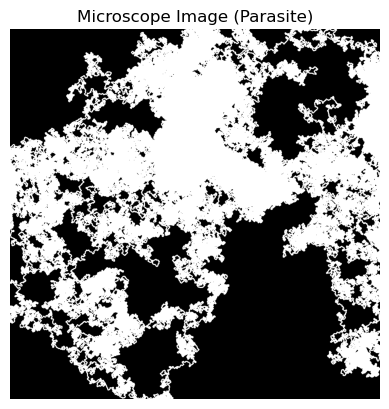

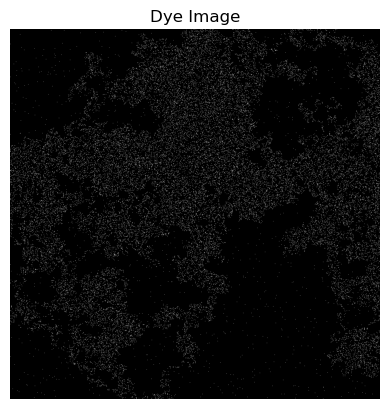

Parasite has cancer: False


In [41]:
# Set the image size to (1000, 1000)
image_size = (1000, 1000)

start_time = time.time() 

# Create the parasite image and the dye image
parasite_image, dye_image = create_parasite_and_dye_images(image_size)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")

# Display the microscope image (parasite image)
microscope_array = parasite_image.toarray()
plt.imshow(microscope_array, cmap='gray')
plt.title("Microscope Image (Parasite)")
plt.axis('off')
plt.show()

# Display the dye image

dye_array = dye_image.toarray()
plt.imshow(dye_array, cmap='gray')
plt.title("Dye Image")
plt.axis('off')
plt.show()

# Check if the parasite has cancer
result = has_cancer(parasite_image, dye_image)
print("Parasite has cancer:", result)

# Q4

In [42]:
start_time = time.time() 
# Check if the parasite has cancer
result = has_cancer(parasite_image, dye_image)
print("Parasite has cancer:", result)
end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")

Parasite has cancer: False
Time taken: 0.00 seconds


To increse the speed of the function we can do the following:
1. we can change the above code to directly use the sparse matrix insead of dence matrix
2. we can chance the .logical_and to .multiply to get the overlap count faster
3. we can use bool data type instead of uint8 to save memory.

In [43]:
# updated code
def has_cancer(microscope_image, dye_image):
    # Calculate the area occupied by the parasite in the microscope image
    parasite_area_microscope = microscope_image.sum()

    # Calculate the area where both microscope and dye images have black pixels (overlap)
    overlap_area = (microscope_image.multiply(dye_image)).sum()

    # Calculate the percentage of overlap relative to the parasite area in the microscope image
    overlap_percentage = (overlap_area / parasite_area_microscope) * 100

    # Check if the overlap percentage exceeds 10%
    if overlap_percentage > 10:
        return True  # The parasite has cancer in the overlap
    else:
        return False  # The parasite does not have cancer in the overlap


In [44]:
start_time = time.time() 
# Check if the parasite has cancer
result = has_cancer(parasite_image, dye_image)
print("Parasite has cancer:", result)
end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")

Parasite has cancer: False
Time taken: 0.00 seconds
